This jupyter notebook, among other things, requires rliable (open-source Python library for reliable evaluation).
To install it:
* pip3 install git+https://github.com/google-research/rliable
* pip3 install inflection

In [172]:
import os
import pandas as pd
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.patches import Patch
from matplotlib.legend import Legend
from matplotlib.collections import PathCollection

Load all the optimized hyperparameter evaluations for decision-making algorithms

In [135]:
# path
path = './experiments/comparisons/'
# list of decision making algorithms
algorithms = ['gpmpc', 'ddpg', 'ppo', 'sac']
algorithms_name_maps = {'gpmpc': 'GP-MPC', 'ddpg': 'DDPG', 'ppo': 'PPO', 'sac': 'SAC'}
# list of strategies
strategies = ['s1', 's2', 's5', 's3', 's4']
strategy_name_maps = {'s1': 'Single Run',
                      's2': 'Multiple Runs', 
                      's3': 'Multiple Runs (CVaR)', 
                      's4': 'Proposed AMRA (CVaR)', 
                      's5': 'AMRA (Exp.)'}
# HPO runs
runs = ['run1', 'run2', 'run3']
# initialize dataframe
hpo_eval_df = pd.DataFrame()
hpo_effort_df = pd.DataFrame()
# load dataframe back from pickle file
for algorithm in algorithms:
    if algorithm == 'gpmpc':
        tmp_eval_df = pd.read_pickle(os.path.join(f'{algorithm}/', f'{algorithm}_hpo_eval.pkl'))
        tmp_effort_df = pd.read_pickle(os.path.join(f'{algorithm}/', f'{algorithm}_hpo_effort.pkl'))
        # add algorithm feature
        tmp_eval_df['algorithm'] = algorithm
        tmp_effort_df['algorithm'] = algorithm
        # concatenate temporary DataFrame with main DataFrame
        hpo_eval_df = pd.concat([hpo_eval_df, tmp_eval_df], ignore_index=True)
        hpo_effort_df = pd.concat([hpo_effort_df, tmp_effort_df], ignore_index=True)
    else:
        tmp_eval_df = pd.read_pickle(os.path.join(f'rl/{algorithm}/', f'{algorithm}_hpo_eval.pkl'))
        tmp_effort_df = pd.read_pickle(os.path.join(f'rl/{algorithm}/', f'{algorithm}_hpo_effort.pkl'))
        # add algorithm feature
        tmp_eval_df['algorithm'] = algorithm
        tmp_effort_df['algorithm'] = algorithm
        # concatenate temporary DataFrame with main DataFrame
        hpo_eval_df = pd.concat([hpo_eval_df, tmp_eval_df], ignore_index=True)
        hpo_effort_df = pd.concat([hpo_effort_df, tmp_effort_df], ignore_index=True)

Modify the plotting function in rliable library

In [84]:
### adapted from following licensed source code:
# coding=utf-8
# Copyright 2021 The Rliable Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

def _decorate_axis(ax, wrect=10, hrect=10, ticklabelsize='large'):
  """Helper function for decorating plots."""
  # Hide the right and top spines
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_linewidth(2)
  ax.spines['bottom'].set_linewidth(2)
  # Deal with ticks and the blank space at the origin
  ax.tick_params(length=0.1, width=0.1, labelsize=ticklabelsize)
  ax.spines['left'].set_position(('outward', hrect))
  ax.spines['bottom'].set_position(('outward', wrect))
  return ax

def plot_interval_estimates(point_estimates,
                            interval_estimates,
                            metric_names,
                            algorithms=None,
                            colors=None,
                            color_palette='colorblind',
                            max_ticks=4,
                            xticks=None,
                            subfigure_width=3.4,
                            row_height=0.37,
                            xlabel_y_coordinate=-0.1,
                            xlabel='Normalized Score',
                            figsize=None,
                            **kwargs):
  """Plots various metrics with confidence intervals.

  Args:
    point_estimates: Dictionary mapping algorithm to a list or array of point
      estimates of the metrics to plot.
    interval_estimates: Dictionary mapping algorithms to interval estimates
      corresponding to the `point_estimates`. Typically, consists of stratified
      bootstrap CIs.
    metric_names: Names of the metrics corresponding to `point_estimates`.
    algorithms: List of methods used for plotting. If None, defaults to all the
      keys in `point_estimates`.
    colors: Maps each method to a color. If None, then this mapping is created
      based on `color_palette`.
    color_palette: `seaborn.color_palette` object for mapping each method to a
      color.
    max_ticks: Find nice tick locations with no more than `max_ticks`. Passed to
      `plt.MaxNLocator`.
    subfigure_width: Width of each subfigure.
    row_height: Height of each row in a subfigure.
    xlabel_y_coordinate: y-coordinate of the x-axis label.
    xlabel: Label for the x-axis.
    **kwargs: Arbitrary keyword arguments.

  Returns:
    fig: A matplotlib Figure.
    axes: `axes.Axes` or array of Axes.
  """

  if algorithms is None:
    algorithms = list(point_estimates.keys())
  num_metrics = len(point_estimates[algorithms[0]])
  figsize = (subfigure_width * num_metrics, row_height * len(algorithms))
  fig, axes = plt.subplots(nrows=1, ncols=num_metrics, figsize=figsize)
  plt.rcParams.update({'font.size': 8})
  if colors is None:
    color_palette = sns.color_palette(color_palette, n_colors=len(algorithms))
    colors = dict(zip(algorithms, color_palette))
  h = kwargs.pop('interval_height', 0.6)

  for idx, metric_name in enumerate(metric_names):
    for alg_idx, algorithm in enumerate(algorithms):
      ax = axes[idx] if num_metrics > 1 else axes
      # Plot interval estimates.
      lower, upper = interval_estimates[algorithm][:, idx]
      ax.barh(
          y=alg_idx,
          width=upper - lower,
          height=h,
          left=lower,
          color=colors[algorithm],
          alpha=0.75,
          label=algorithm)
      # Plot point estimates.
      ax.vlines(
          x=point_estimates[algorithm][idx],
          ymin=alg_idx - (7.5 * h / 16),
          ymax=alg_idx + (6 * h / 16),
          label=algorithm,
          color='k',
          alpha=0.5)
    ax.set_yticks(list(range(len(algorithms))))
    ax.xaxis.set_major_locator(plt.MaxNLocator(max_ticks))
    if idx != 0:
      ax.set_yticks([])
    else:
      ax.set_yticklabels(algorithms, fontsize='x-large')
    ax.set_title(metric_name, fontsize='xx-large')
    ax.tick_params(axis='both', which='major')
    _decorate_axis(ax, ticklabelsize='xx-large', wrect=5)
    ax.spines['left'].set_visible(False)
    ax.grid(True, axis='x', alpha=0.25)
    if xticks is not None:
      ax.set_xticks(xticks)
    ax.set_xlim([xticks[0], 140])
  fig.text(0.4, xlabel_y_coordinate, xlabel, ha='center', fontsize='xx-large')
  plt.subplots_adjust(wspace=kwargs.pop('wspace', 0.11), left=0.0)
  if algorithms[0].split('(')[0] == algorithms[1].split('(')[0]:
    name = algorithms[0].split('(')[0]
  else:
    name = algorithms[0].split('(')[1].split(')')[0]
  plt.savefig(f'rl/fig/experiments/{metric_names} CIs for {name}.pdf', format="pdf", bbox_inches='tight')
  return fig, axes

Store the stats in the dictionary

In [136]:
stats = {}

for algorithm in algorithms:
    for strategy in strategies:
        data_list = []
        for run in runs:
            tmp_array = hpo_eval_df.loc[hpo_eval_df['algorithm'] == algorithm].loc[hpo_eval_df['Category'] == strategy].loc[hpo_eval_df['Category_Run'] == f'{run}_{strategy}']['Reward'].to_numpy()
            tmp_array = tmp_array.reshape(-1, 1)
            # concatenate array vertically
            data_list.append(tmp_array)
        data_list = np.hstack(data_list)
        strategy_name = strategy_name_maps[strategy]
        algorithm_name = algorithms_name_maps[algorithm]
        stats[f'{algorithm_name} ({strategy_name})'] = data_list

In [41]:
# create stats list

stats_list = []
for algorithm in algorithms:
    stats_list.append({k: v for k, v in stats.items() if algorithms_name_maps[algorithm] in k})

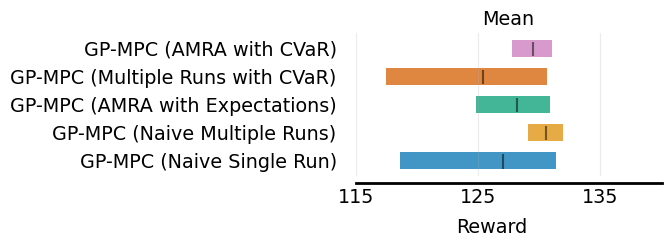

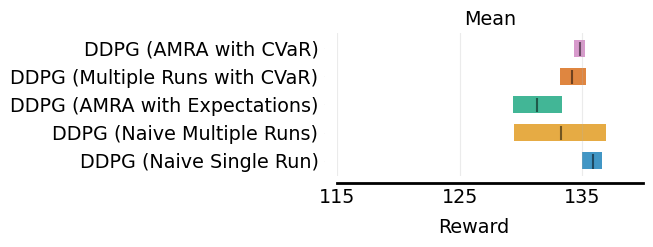

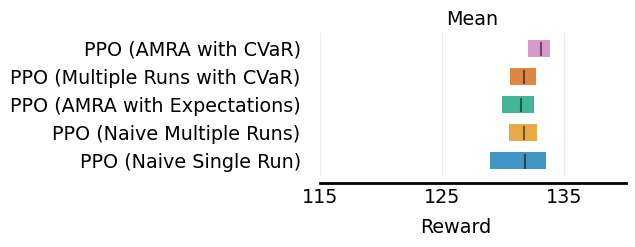

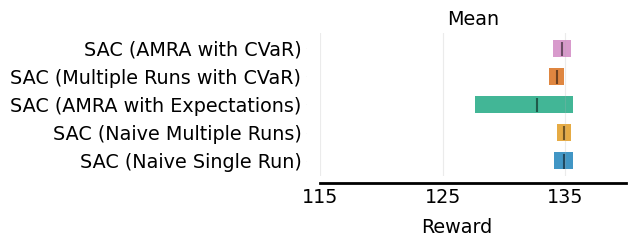

In [77]:
aggregate_func = lambda x: np.array([metrics.aggregate_mean(x)])
for stats in stats_list:
    aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(stats, 
                                                                                aggregate_func, 
                                                                                reps=50000, 
                                                                                task_bootstrap=True)
    fig, axes = plot_interval_estimates(aggregate_scores,
                                        aggregate_interval_estimates,
                                        metric_names=['Mean'],
                                        algorithms=list(stats.keys()), 
                                        xlabel='Reward',
                                        xticks=[115, 125, 135],
                                        xlabel_y_coordinate=-0.2)

Toward benchmarking for learning-based control and reinforcement learning

In [72]:
# create benchmark list
# gather gpmpc_s1, ddpg_s1,... in the dict

benchmark_list = []
for strategy in strategies:
    benchmark_list.append({k: v for k, v in stats.items() if strategy_name_maps[strategy] in k})

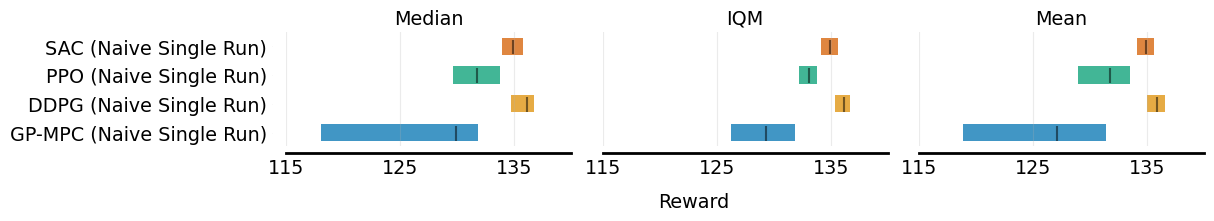

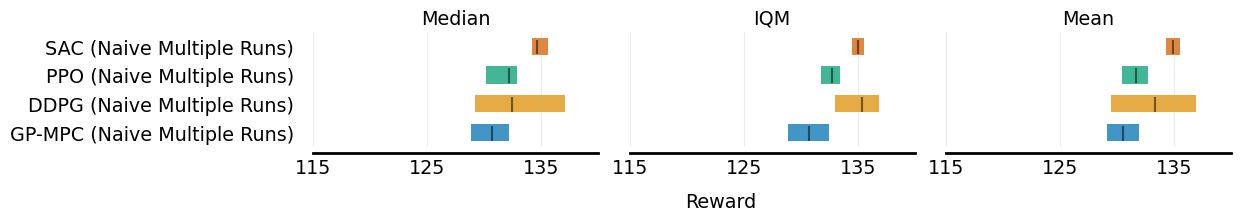

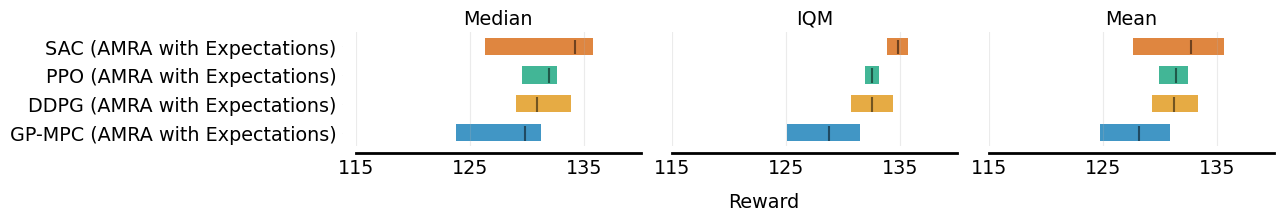

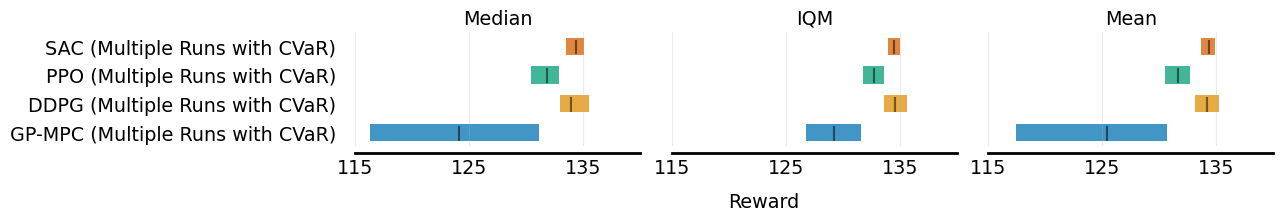

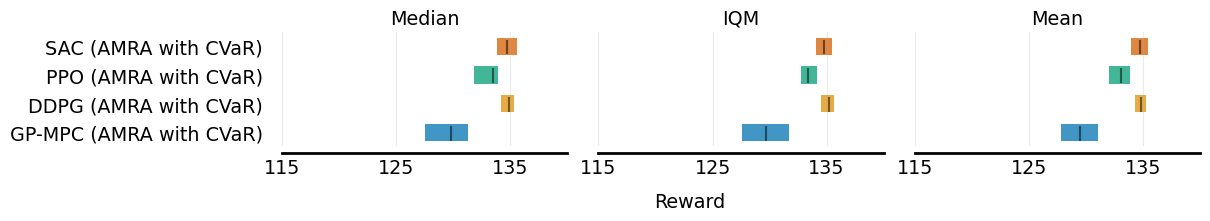

In [85]:
aggregate_func = lambda x: np.array([metrics.aggregate_median(x),
                                     metrics.aggregate_iqm(x),
                                     metrics.aggregate_mean(x)])
for stats in benchmark_list:
    aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(stats, 
                                                                                aggregate_func, 
                                                                                reps=50000, 
                                                                                task_bootstrap=True)
    fig, axes = plot_interval_estimates(aggregate_scores,
                                        aggregate_interval_estimates,
                                        metric_names=['Median', 'IQM', 'Mean'],
                                        algorithms=list(stats.keys()), 
                                        xlabel='Reward',
                                        xticks=[115, 125, 135],
                                        xlabel_y_coordinate=-0.3)

Plot boxen plot

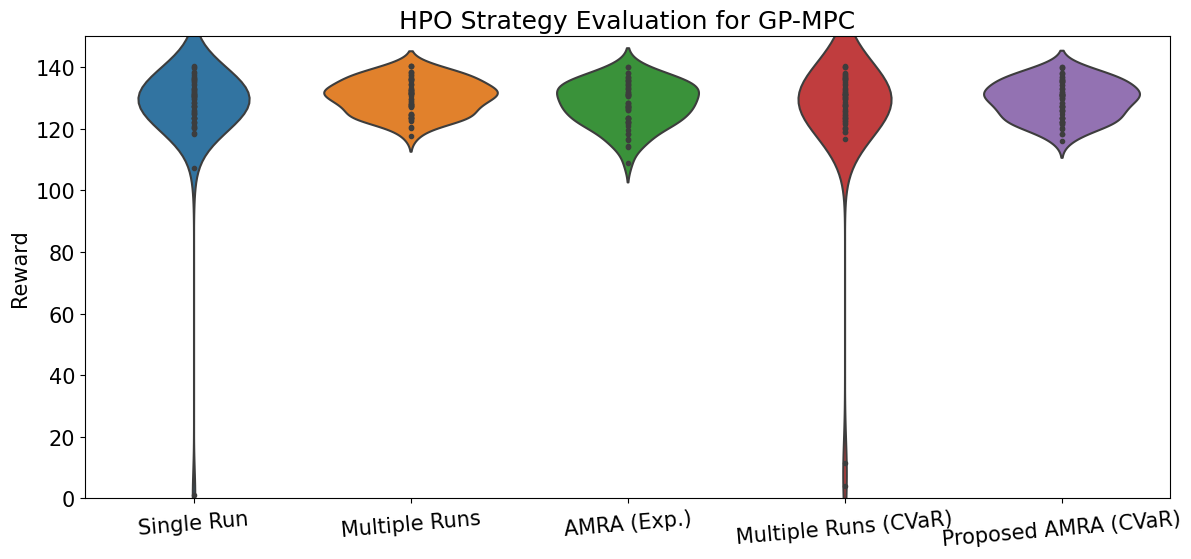

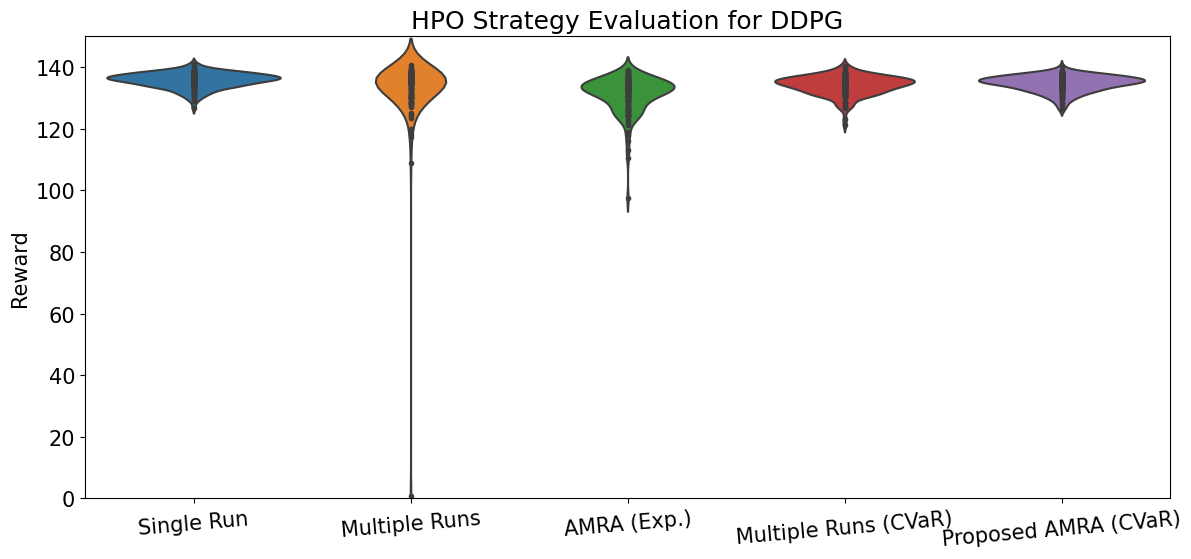

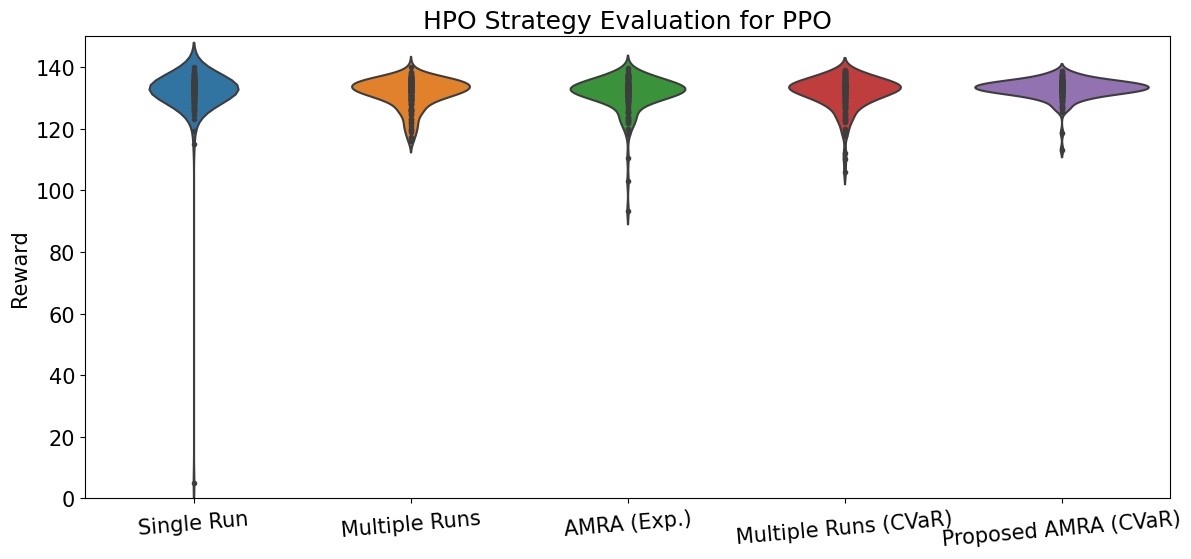

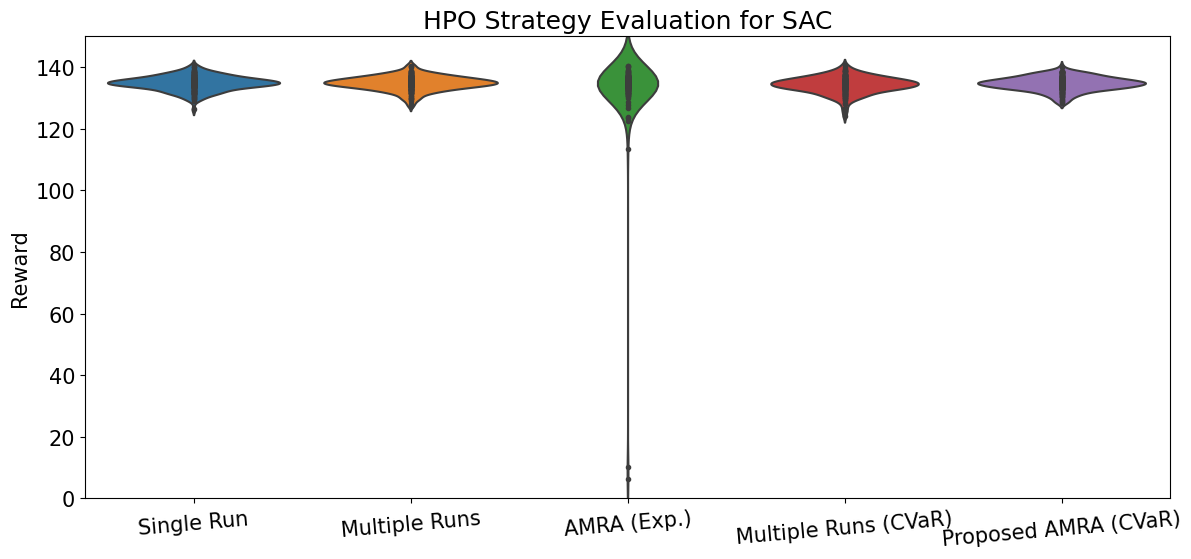

In [158]:
# plot boxen plot for each algorithm
for algorithm in algorithms:
    # add one feature called strategy name to the dataframe
    hpo_eval_df['strategy_name'] = hpo_eval_df['Category'].apply(lambda x: strategy_name_maps[x])
    # plot boxen plot
    plt.figure(figsize=(14, 6))
    plt.rcParams.update({'font.size': 15})
    # change the order of the boxen plot
    order=[strategy_name_maps['s1'], strategy_name_maps['s2'], strategy_name_maps['s5'], strategy_name_maps['s3'], strategy_name_maps['s4']]
    # ax = sns.boxenplot(x='strategy_name', y='Reward', data=hpo_eval_df[hpo_eval_df['algorithm'] == algorithm], k_depth='proportion', order=order)
    ax = sns.violinplot(x='strategy_name', y='Reward', data=hpo_eval_df[hpo_eval_df['algorithm'] == algorithm], inner='points', order=order)
    plt.setp(ax.get_xticklabels(), rotation=5)
    plt.xlabel('')
    plt.ylabel('Reward')
    plt.ylim([0, 150])
    plt.title(f'HPO Strategy Evaluation for {algorithms_name_maps[algorithm]}')
    plt.savefig(f'rl/fig/experiments/HPO Strategy Evaluation for {algorithms_name_maps[algorithm]}.pdf', format="pdf")
    plt.show()
    plt.close()

Here

/tmp/ipykernel_1029502/1940099617.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_1029502/1940099617.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_1029502/1940099617.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_1029502/1940099617.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



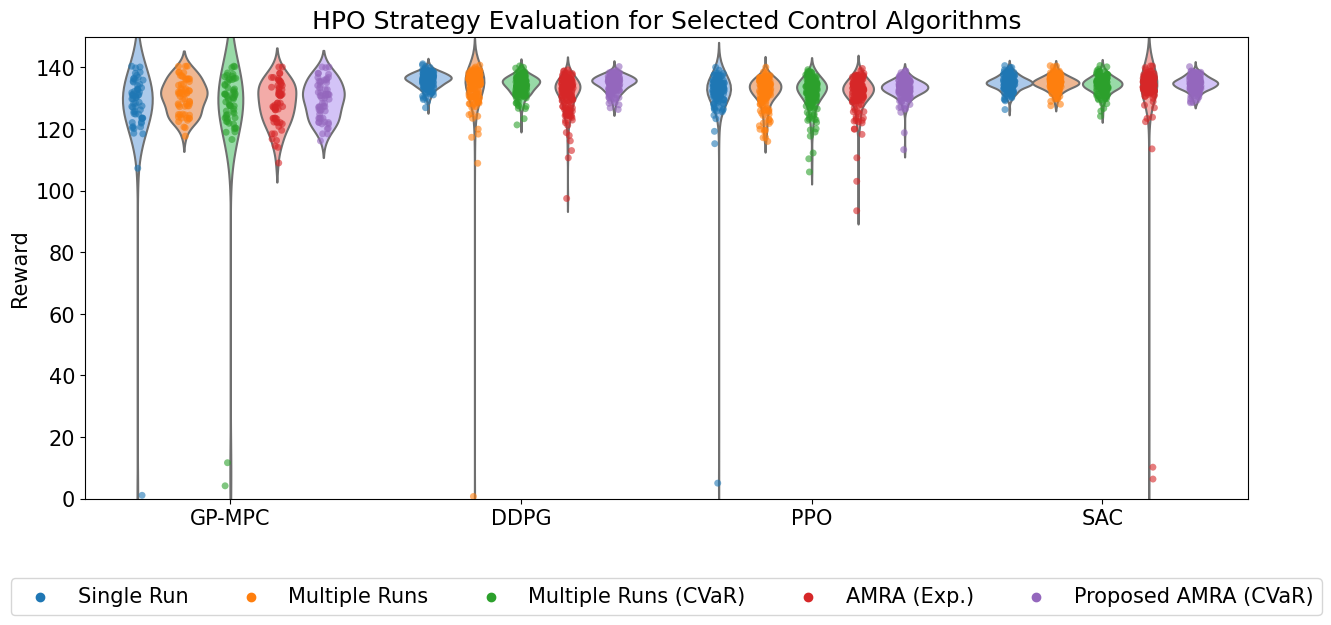

In [198]:
# Initialize an empty DataFrame to store the data
combined_data = pd.DataFrame()

# Reorder the DataFrame based on 'strategy_name'
str_order=[strategy_name_maps['s1'], strategy_name_maps['s2'], strategy_name_maps['s3'], strategy_name_maps['s5'], strategy_name_maps['s4']]
hpo_eval_df = hpo_eval_df[hpo_eval_df['strategy_name'].isin(str_order)].sort_values(by=['strategy_name'], key=lambda x: x.map({v: i for i, v in enumerate(str_order)}))

# Loop through the algorithms and add data to the combined DataFrame
for algorithm in algorithms:
    # Add one feature called strategy name to the dataframe
    hpo_eval_df['strategy_name'] = hpo_eval_df['Category'].apply(lambda x: strategy_name_maps[x])
    hpo_eval_df['algorithm_name'] = hpo_eval_df['algorithm'].apply(lambda x: algorithms_name_maps[x])
    
    # Filter the data for the current algorithm
    algorithm_data = hpo_eval_df[hpo_eval_df['algorithm'] == algorithm]
    
    # Append the filtered data to the combined DataFrame
    combined_data = combined_data.append(algorithm_data)
    
# Plot all algorithms in the same graph
plt.figure(figsize=(15, 6))
plt.rcParams.update({'font.size': 15})
algo_order = [algorithms_name_maps['gpmpc'], algorithms_name_maps['ddpg'], algorithms_name_maps['ppo'], algorithms_name_maps['sac']]

# Use seaborn to create a boxen plot with all algorithms
# ax = sns.boxenplot(x='algorithm_name', y='Reward', hue='strategy_name', data=combined_data, k_depth='proportion')
# create palette that has the same color that is really colorblind friendly
palette = sns.color_palette("pastel", 5)
ax = sns.violinplot(x='algorithm_name', y='Reward', hue='strategy_name', data=combined_data, inner=None, bw_adjust=10.0, palette=palette)
sns.stripplot(x='algorithm_name', y='Reward', hue='strategy_name', data=combined_data, dodge=True, jitter=True, alpha=0.6, ax=ax)

# Display the legend horizontally
# only show the legend of stripplot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[5:], labels[5:], bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(strategy_name))
# legend = ax.legend(loc='upper center', bbox_to_anchor=(0.48, -0.15), ncol=len(strategy_name))

# Customize the plot appearance
plt.xlabel('')
plt.ylabel('Reward')
plt.ylim([0, 150])
plt.title('HPO Strategy Evaluation for Selected Control Algorithms')

# Save and display the plot
# plt.savefig('rl/fig/experiments/HPO Strategy Evaluation for All Algorithms.pdf', format="pdf")
plt.show()
plt.close()

/tmp/ipykernel_1029502/636341203.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_1029502/636341203.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_1029502/636341203.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_1029502/636341203.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/tueilsy-st01/anaconda3/envs/pr-env/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning:

Mean of empty slice

/home/tueilsy-st01/anaconda3/envs/pr-env/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning:

Mean of empty slice

/home/tueilsy-st01/anaconda3/envs/pr

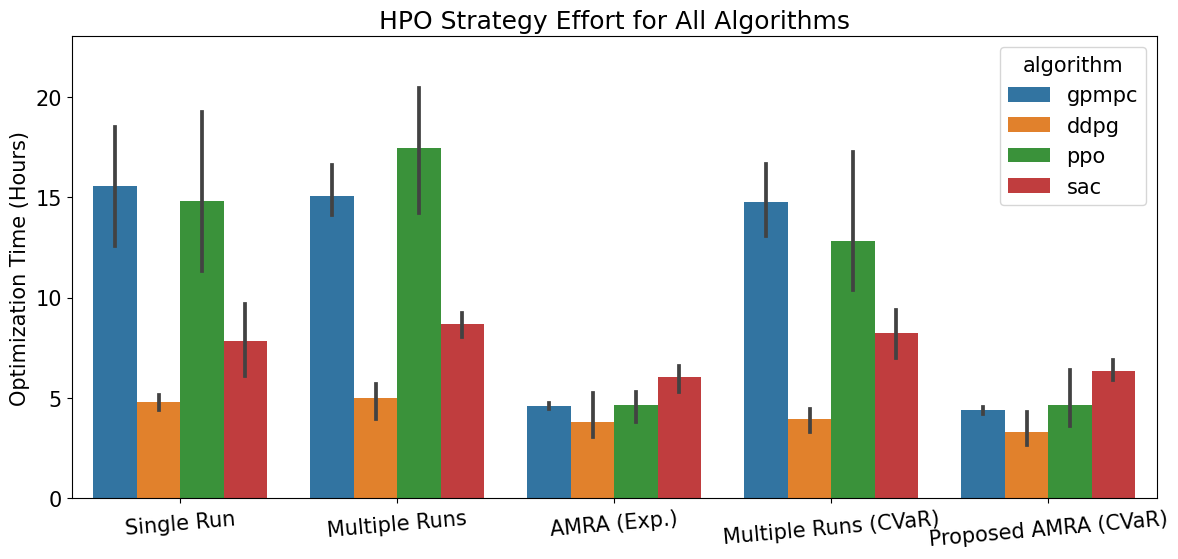

In [196]:
for algorithm in algorithms:
    # Add one feature called strategy name to the dataframe
    hpo_effort_df['strategy_name'] = hpo_effort_df['Category'].apply(lambda x: strategy_name_maps[x])
    
    # Filter the data for the current algorithm
    algorithm_data = hpo_effort_df[hpo_effort_df['algorithm'] == algorithm]
    
    # Append the filtered data to the combined DataFrame
    combined_data = combined_data.append(algorithm_data)

# Plot all algorithms in the same graph
plt.figure(figsize=(14, 6))
plt.rcParams.update({'font.size': 15})
order = [strategy_name_maps['s1'], strategy_name_maps['s2'], strategy_name_maps['s5'], strategy_name_maps['s3'], strategy_name_maps['s4']]

# Use seaborn to create a bar plot with all algorithms
ax = sns.barplot(x='strategy_name', y='Duration Time (hours)', hue='algorithm', data=combined_data, order=order)

# Customize the plot appearance
plt.setp(ax.get_xticklabels(), rotation=5)
plt.xlabel('')
plt.ylabel('Optimization Time (Hours)')
plt.ylim([0, 23])
plt.title('HPO Strategy Effort for All Algorithms')

# Save and display the plot
# plt.savefig('rl/fig/experiments/HPO Strategy Effort for All Algorithms.pdf', format="pdf")
plt.show()
plt.close()


/tmp/ipykernel_1029502/159689677.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_1029502/159689677.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_1029502/159689677.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_1029502/159689677.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



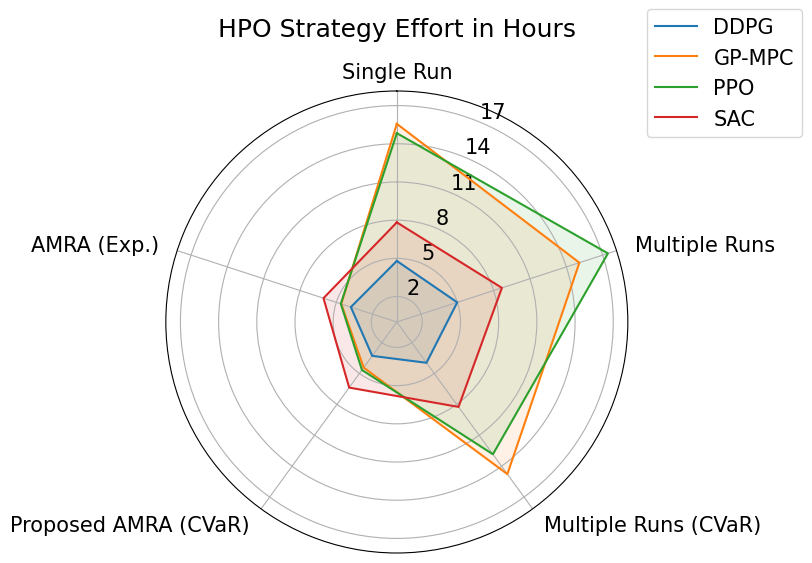

In [144]:
for algorithm in algorithms:
    # Add one feature called strategy name to the dataframe
    hpo_effort_df['strategy_name'] = hpo_effort_df['Category'].apply(lambda x: strategy_name_maps[x])
    
    # Filter the data for the current algorithm
    algorithm_data = hpo_effort_df[hpo_effort_df['algorithm'] == algorithm]
    
    # Append the filtered data to the combined DataFrame
    combined_data = combined_data.append(algorithm_data)
# Sample data for radar plot (modify this with your actual data)
categories = [strategy_name_maps['s1'], strategy_name_maps['s2'], strategy_name_maps['s3'], strategy_name_maps['s4'], strategy_name_maps['s5']]
# Convert the strategy_name column to categorical data with the custom order
combined_data['strategy_name'] = pd.Categorical(combined_data['strategy_name'], categories=categories, ordered=True)
data = combined_data.groupby(['algorithm', 'strategy_name'])['Duration Time (hours)'].mean().unstack().values
df = pd.DataFrame({'categories': [strategy_name_maps['s1'], strategy_name_maps['s2'], strategy_name_maps['s5'], strategy_name_maps['s3'], strategy_name_maps['s4']],
                   'DDPG': data[0,:],
                   'GP-MPC': data[1,:],
                   'PPO': data[2,:],
                   'SAC': data[3,:]})

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# theta has 5 different angles, and the first one repeated
theta = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
theta += theta[:1]

# loop over the algorithms
for algo in df.columns[1:]:
    # get values from the df
    values = df[algo].values
    # append the first value to the end to close the circle
    values = np.append(values, values[0])
    # plot the polygon
    ax.plot(theta, values, label=algo)
    # ax.tick_params(pad=40) # to increase the distance of the labels to the plot
    # # fill the area of the polygon with green and some transparency
    ax.fill(theta, values, alpha=0.1)

# Fix axis to go in the right order and start at 12 o'clock.
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label.
ax.set_thetagrids(np.degrees(theta[:-1]), categories)
ax.set_rgrids([2, 5, 8, 11, 14, 17])

# plt.xticks(theta[:-1], df['categories'], color='grey', size=10)

for label, theta in zip(ax.get_xticklabels(), theta):
  if theta in (0, np.pi):
    label.set_horizontalalignment('center')
  elif 0 < theta < np.pi:
    label.set_horizontalalignment('left')
  else:
    label.set_horizontalalignment('right')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.2))
plt.title("HPO Strategy Effort in Hours", y=1.1)
plt.show()

In [145]:
combined_data.groupby(['strategy_name', 'algorithm'])['Duration Time (hours)'].mean()

strategy_name         algorithm
Single Run            ddpg          4.795481
                      gpmpc        15.566197
                      ppo          14.831862
                      sac           7.823733
Multiple Runs         ddpg          4.989140
                      gpmpc        15.078151
                      ppo          17.438501
                      sac           8.678627
Multiple Runs (CVaR)  ddpg          3.960612
                      gpmpc        14.771447
                      ppo          12.840239
                      sac           8.245520
Proposed AMRA (CVaR)  ddpg          3.288809
                      gpmpc         4.428697
                      ppo           4.661464
                      sac           6.369539
AMRA (Exp.)           ddpg          3.797335
                      gpmpc         4.588832
                      ppo           4.628452
                      sac           6.058496
Name: Duration Time (hours), dtype: float64

Here

/tmp/ipykernel_1029502/1191555602.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_1029502/1191555602.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_1029502/1191555602.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_1029502/1191555602.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



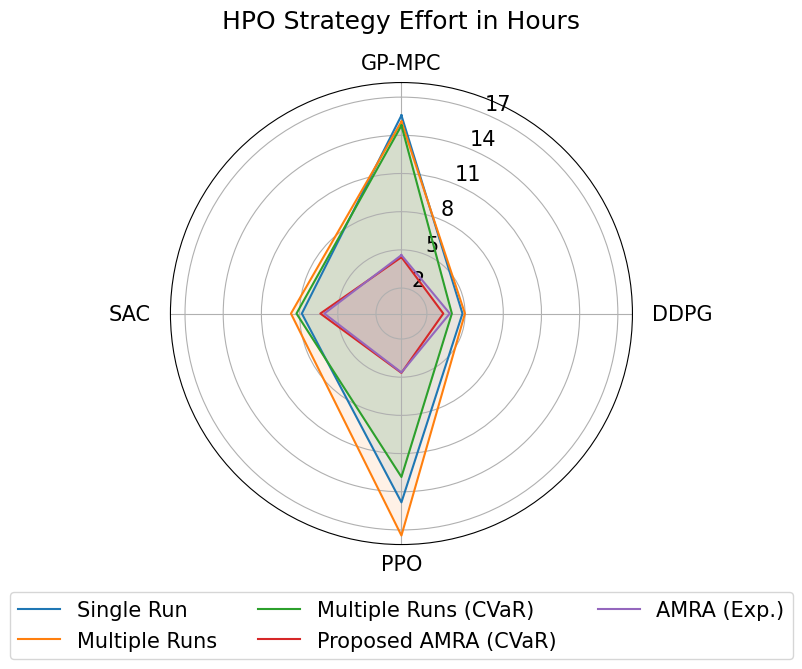

In [157]:
for algorithm in algorithms:
    # Add one feature called strategy name to the dataframe
    hpo_effort_df['strategy_name'] = hpo_effort_df['Category'].apply(lambda x: strategy_name_maps[x])
    
    # Filter the data for the current algorithm
    algorithm_data = hpo_effort_df[hpo_effort_df['algorithm'] == algorithm]
    
    # Append the filtered data to the combined DataFrame
    combined_data = combined_data.append(algorithm_data)
# Sample data for radar plot (modify this with your actual data)
categories = ['gpmpc', 'ddpg', 'ppo', 'sac']
# Convert the algo column to categorical data with the custom order
combined_data['algorithm'] = pd.Categorical(combined_data['algorithm'], categories=categories, ordered=True)
stra_order = [strategy_name_maps['s1'], strategy_name_maps['s2'], strategy_name_maps['s3'], strategy_name_maps['s4'], strategy_name_maps['s5']]
combined_data['strategy_name'] = pd.Categorical(combined_data['strategy_name'], categories=stra_order, ordered=True)
data = combined_data.groupby(['strategy_name', 'algorithm'])['Duration Time (hours)'].mean().unstack().values
df = pd.DataFrame({'categories': [algorithms_name_maps['gpmpc'], algorithms_name_maps['ddpg'], algorithms_name_maps['ppo'], algorithms_name_maps['sac']],
                   strategy_name_maps['s1']: data[0,:],
                   strategy_name_maps['s2']: data[1,:],
                   strategy_name_maps['s3']: data[2,:],
                   strategy_name_maps['s4']: data[3,:],
                   strategy_name_maps['s5']: data[4,:]})

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# theta has 5 different angles, and the first one repeated
theta = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
theta += theta[:1]

# loop over the algorithms
for strategy in df.columns[1:]:
    # get values from the df
    values = df[strategy].values
    # append the first value to the end to close the circle
    values = np.append(values, values[0])
    # plot the polygon
    ax.plot(theta, values, label=strategy)
    # ax.tick_params(pad=40) # to increase the distance of the labels to the plot
    # # fill the area of the polygon with green and some transparency
    ax.fill(theta, values, alpha=0.1)

# Fix axis to go in the right order and start at 12 o'clock.
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label.
ax.set_thetagrids(np.degrees(theta[:-1]), df['categories'])
ax.set_rgrids([2, 5, 8, 11, 14, 17])

# plt.xticks(theta[:-1], df['categories'], color='grey', size=10)

for label, theta in zip(ax.get_xticklabels(), theta):
  if theta in (0, np.pi):
    label.set_horizontalalignment('center')
  elif 0 < theta < np.pi:
    label.set_horizontalalignment('left')
  else:
    label.set_horizontalalignment('right')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=len(strategy)/3)
# plt.legend(loc='lower right', bbox_to_anchor=(1.4, 1.2))
plt.title("HPO Strategy Effort in Hours", y=1.1)
plt.show()

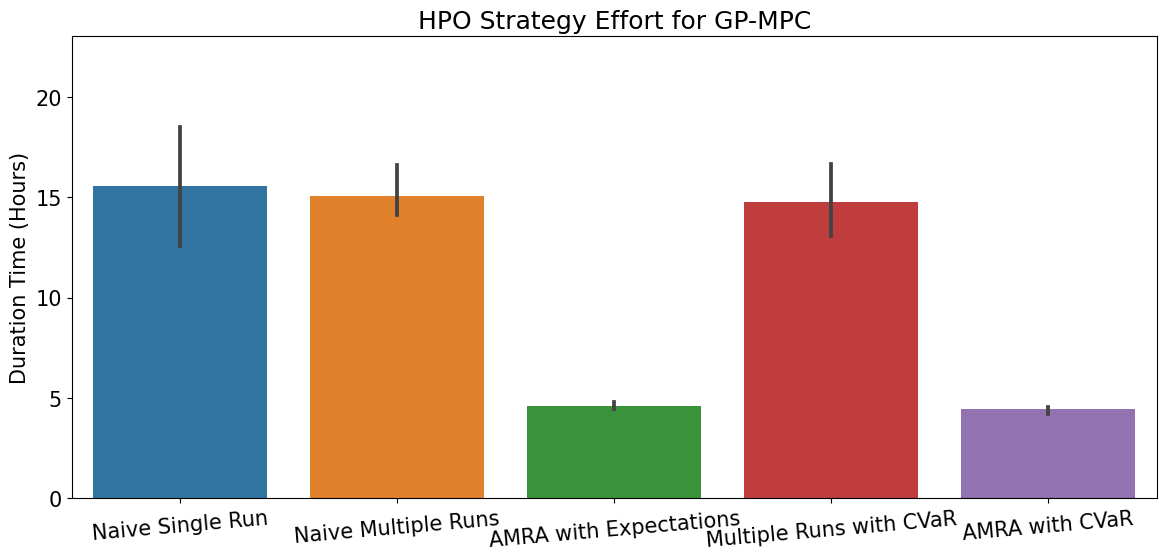

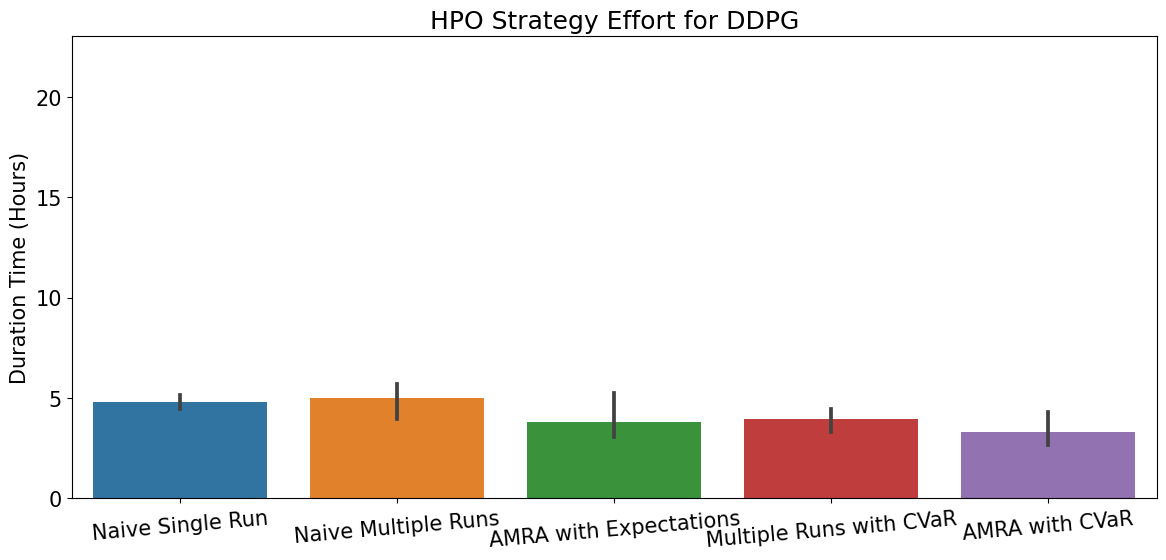

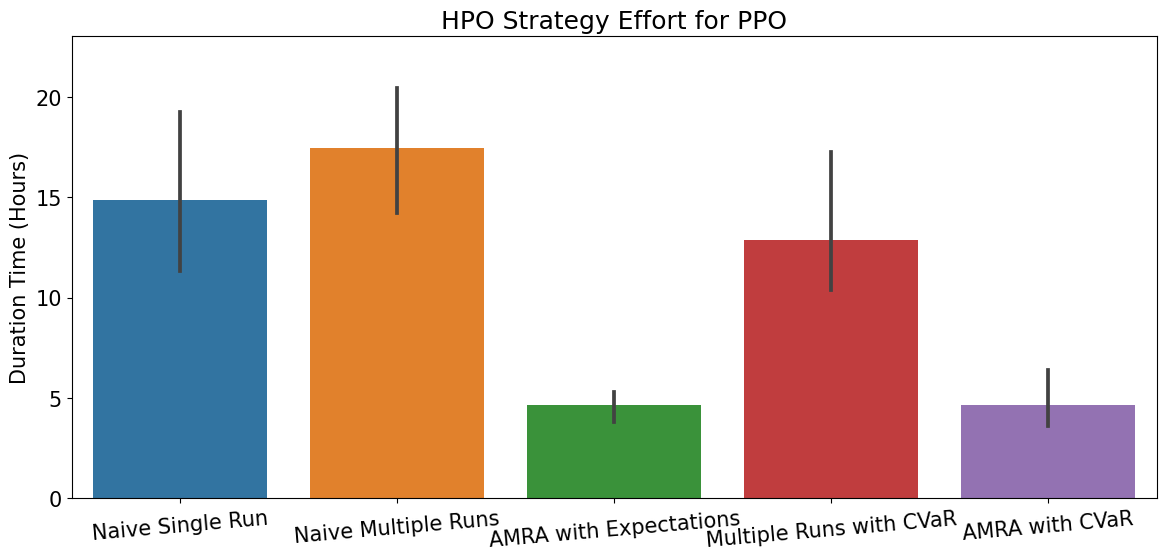

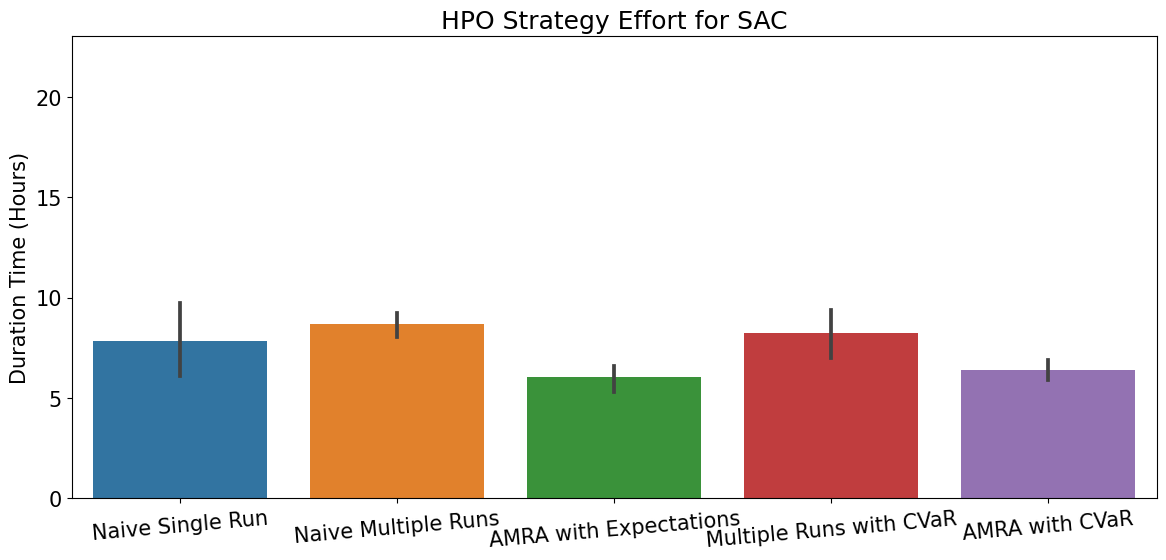

In [13]:
# plot boxen plot for each algorithm
for algorithm in algorithms:
    # add one feature called strategy name to the dataframe
    hpo_effort_df['strategy_name'] = hpo_effort_df['Category'].apply(lambda x: strategy_name_maps[x])
    # plot boxen plot
    plt.figure(figsize=(14, 6))
    plt.rcParams.update({'font.size': 15})
    # change the order of the boxen plot
    order=[strategy_name_maps['s1'], strategy_name_maps['s2'], strategy_name_maps['s5'], strategy_name_maps['s3'], strategy_name_maps['s4']]
    ax = sns.barplot(x='strategy_name', y='Duration Time (hours)', data=hpo_effort_df[hpo_effort_df['algorithm'] == algorithm], order=order)
    plt.setp(ax.get_xticklabels(), rotation=5)
    plt.xlabel('')
    plt.ylabel('Duration Time (Hours)')
    plt.ylim([0, 23])
    plt.title(f'HPO Strategy Effort for {algorithms_name_maps[algorithm]}')
    plt.savefig(f'rl/fig/experiments/HPO Strategy Effort for {algorithms_name_maps[algorithm]}.pdf', format="pdf")
    plt.show()
    plt.close()

/tmp/ipykernel_1029502/3093940760.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_1029502/3093940760.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_1029502/3093940760.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_1029502/3093940760.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_1029502/3093940760.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_1029502/3093940760.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from 

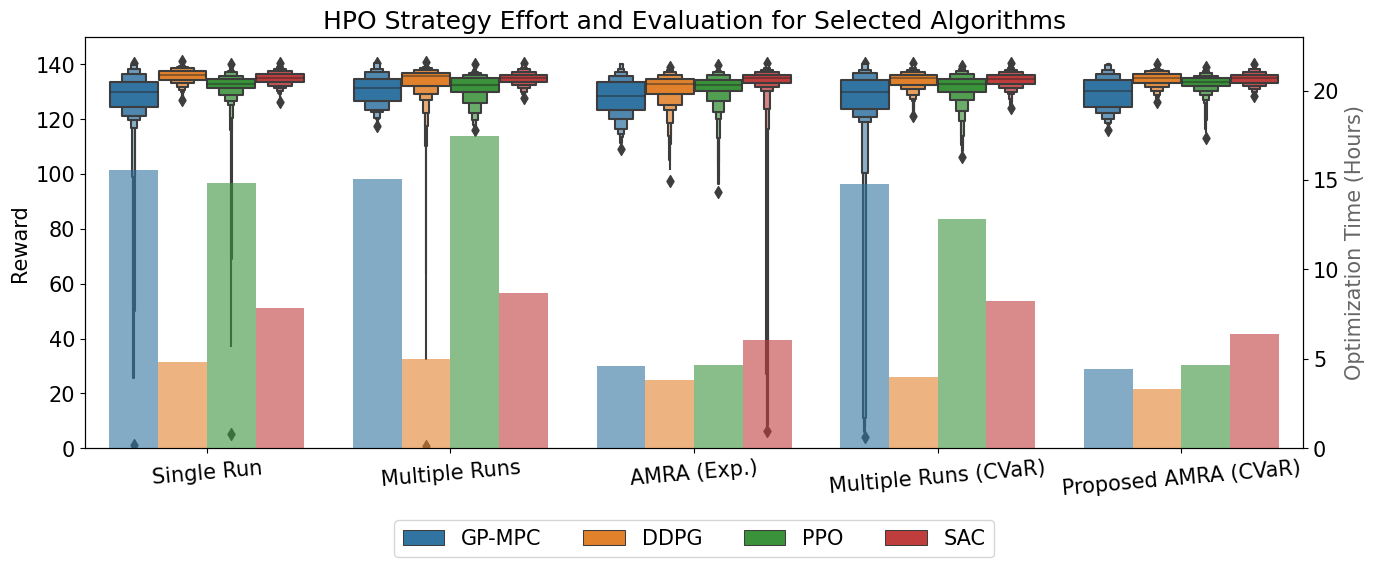

In [85]:
combined_data_effort = pd.DataFrame()
combined_data_evaluation = pd.DataFrame()

# Loop through the algorithms and add data to the combined DataFrames
for algorithm in algorithms:
    # Add one feature called strategy name to the dataframe for effort and evaluation
    hpo_effort_df['strategy_name'] = hpo_effort_df['Category'].apply(lambda x: strategy_name_maps[x])
    hpo_eval_df['strategy_name'] = hpo_eval_df['Category'].apply(lambda x: strategy_name_maps[x])
    
    # Filter the data for the current algorithm for effort and evaluation
    algorithm_data_effort = hpo_effort_df[hpo_effort_df['algorithm'] == algorithm]
    algorithm_data_evaluation = hpo_eval_df[hpo_eval_df['algorithm'] == algorithm]
    
    # Append the filtered data to the combined DataFrames for effort and evaluation
    combined_data_effort = combined_data_effort.append(algorithm_data_effort)
    combined_data_evaluation = combined_data_evaluation.append(algorithm_data_evaluation)

# Create a single figure with two subplots (2 rows, 1 column)
fig, ax1 = plt.subplots(figsize=(14, 6))
plt.rcParams.update({'font.size': 15})
order = [strategy_name_maps['s1'], strategy_name_maps['s2'], strategy_name_maps['s5'], strategy_name_maps['s3'], strategy_name_maps['s4']]

# Customize the plot appearance
plt.setp(ax1.get_xticklabels(), rotation=5)
# Use seaborn to create a bar plot for effort with all algorithms
sns.boxenplot(x='strategy_name', y='Reward', hue='algorithm', data=combined_data_evaluation, k_depth='proportion', order=order, ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Reward')
ax1.set_ylim([0, 150])
ax1.set_title('HPO Strategy Effort and Evaluation for Selected Algorithms')

# Create a twin y-axis for duration time
ax2 = ax1.twinx()

# Use seaborn to create a bar plot for duration time with all algorithms
sns.barplot(x='strategy_name', y='Duration Time (hours)', hue='algorithm', data=combined_data_effort, order=order, ax=ax2, alpha=0.6, ci=None)
ax2.set_xlabel('')
ax2.set_ylabel('Optimization Time (Hours)', alpha=0.6)
ax2.set_ylim([0, 23])

ax2.get_legend().remove()

# Remove the legend title from ax1 (reward)
ax1.get_legend().set_title('')

# Display the legend horizontally
legend = ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(algorithms))

# Set custom legend labels for each algorithm
legend_labels = [f'{algorithms_name_maps[algorithm]}' for algorithm in algorithms]
for text, label in zip(legend.get_texts(), legend_labels):
    text.set_text(label)

# Adjust spacing between subplots
plt.tight_layout()

# Save and display the combined plot
# plt.savefig('rl/fig/experiments/HPO_Comparison.pdf', format="pdf")
plt.show()
plt.close()